In [1]:
import numpy as np
from mpi4py import MPI
import time
import pathlib
import h5py
from IPython import display

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()

from dedalus import public as de
from dedalus.extras import flow_tools
from dedalus.extras import plot_tools

import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.info('Hello')

de.logging_setup.rootlogger.setLevel('ERROR')
%matplotlib inline

# Parameters
Lx, Lz = (4., 1.)
Prandtl = 1.
Rayleigh = 3.8e4

# Create bases and domain
x_basis = de.Fourier('x', 256, interval=(0, Lx), dealias=3/2)
z_basis = de.Chebyshev('z', 64, interval=(0, Lz), dealias=3/2)
domain = de.Domain([x_basis, z_basis], grid_dtype=np.float64)

# 2D Boussinesq hydrodynamics 
problem = de.IVP(domain, variables=['p', 'T', 'u', 'w','Tz', 'uz', 'wz'])
problem.meta['p','T','u','w']['z']['dirichlet'] = True

problem.parameters['P'] = 1 / Prandtl
problem.parameters['R'] = (Rayleigh / Prandtl)
# Why do we need the below parameter?
problem.parameters['F'] = F = 1e4

# Continuity equation for Mass
problem.add_equation("dx(u)+ wz = 0")
# X-component of the momentum equation
problem.add_equation("dt(u)+ dx(p) - dx(dx(u)) - dz(uz) = - u*dx(u) - w*uz ")# Why no R compared to example?
# Z-component of the momentum equation
problem.add_equation("dt(w) +dz(p) - dx(dx(w)) - dz(wz) - R*T = - u*dx(w) - w*dz(w) ")
# Temperature equation
problem.add_equation("dt(T) - P*((dx(dx(T))) + dz(Tz)) = -(u*dx(T) + w*Tz) ")
# Matt's temperature equation
#problem.add_equation("  P*dt(T) - dx(dx(T)) - dz(Tz) = -P*( u*dx(T) + w*Tz )   ")

# These three equations are defining the first differential. Ie bz is the first derivative of temperature b, with respect to z.
problem.add_equation("Tz - dz(T) = 0")
problem.add_equation("uz - dz(u) = 0")
problem.add_equation("wz - dz(w) = 0")

# Fixed temperature at upper boundary
problem.add_bc("right(T) = 0")
 # Fixed flux at bottom boundary, F = F_cond
problem.add_bc("left(Tz) = -1")

# Stress-free bottom boundary
problem.add_bc("left(uz) = 0")
# Stress-free top boundary
problem.add_bc("right(uz) = 0")

# Impermeable bottom boundary
problem.add_bc("left(w) = 0")
# Impermeable top boundary
problem.add_bc("right(w) = 0", condition="(nx != 0)")

# Required for equations to be well-posed - see https://bit.ly/2nPVWIg for a related discussion
problem.add_bc("right(p) = 0", condition="(nx == 0)")

# Build solver
solver = problem.build_solver(de.timesteppers.RK222)
logger.info('Solver built')

2020-11-24 18:52:52,619 __main__ 0/1 INFO :: Hello
2020-11-24 18:52:54,149 __main__ 0/1 INFO :: Solver built


2020-11-24 18:55:29,926 __main__ 0/1 INFO :: Iterations: 4920
2020-11-24 18:55:29,927 __main__ 0/1 INFO :: Sim end time: 0.400012
2020-11-24 18:55:29,928 __main__ 0/1 INFO :: Run time: 152.39 sec
2020-11-24 18:55:29,928 __main__ 0/1 INFO :: Run time: 0.042329 cpu-hr


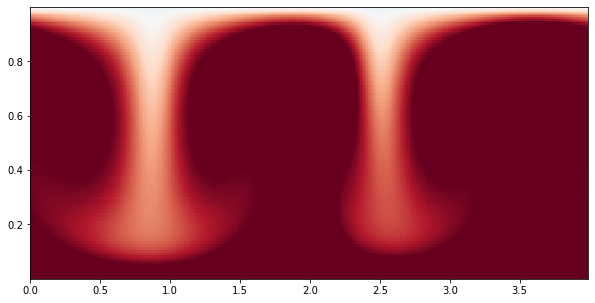

In [2]:
# Initial conditions
# x, z = domain.all_grids()
x = domain.grid(0)
z = domain.grid(1)
T = solver.state['T']
Tz = solver.state['Tz']

# Random perturbations, initialized globally for same results in parallel
gshape = domain.dist.grid_layout.global_shape(scales=1)
slices = domain.dist.grid_layout.slices(scales=1)
rand = np.random.RandomState(seed=42)
noise = rand.standard_normal(gshape)[slices]

# Linear background + perturbations damped at walls
zT, zt = z_basis.interval
pert =  1e-5 * noise * (zt - z) * (z - zT)
T['g'] = F * pert
T.differentiate('z', out=Tz)

# Timestepping and output
#This is the initial timestep
dt = 1e-4 
stop_sim_time = 0.4
#fh_mode = 'overwrite'
#fh_mode = 'append'

# Integration parameters
solver.stop_sim_time = stop_sim_time

max_dt = 1e-4
# CFL
CFL = flow_tools.CFL(solver, initial_dt=dt, cadence=10, safety=0.5,
                     max_change=1.5, min_change=0.5, max_dt=max_dt, threshold=0.05)
CFL.add_velocities(('u', 'w'))

# Analysis
analysis = solver.evaluator.add_file_handler('analysis', sim_dt=0.25, max_writes=50)# ,mode=fh_mode
analysis.add_task('u')
analysis.add_task('T')
solver.evaluator.vars['Lx'] = Lx
analysis.add_task("integ(u,'x')/Lx", name='s profile')
#snapshots.add_system(solver.state)

# Flow properties
flow = flow_tools.GlobalFlowProperty(solver, cadence=10)
flow.add_property("sqrt(u*u + w*w) / R", name='Re')

# Make plot of scalar field
x = domain.grid(0,scales=domain.dealias)
y = domain.grid(1,scales=domain.dealias)
xm, ym = np.meshgrid(x,y)
fig, axis = plt.subplots(figsize=(10,5))
p = axis.pcolormesh(xm, ym, T['g'].T, cmap='RdBu_r');

#axis.set_xlim([0,2.])
#axis.set_ylim([-0.5,0.5])

logger.info('Starting loop')
start_time = time.time()
while solver.ok:#try solver.proceed
    dt = CFL.compute_dt()
    solver.step(dt)
    if (solver.iteration-1) % 50 == 0: # increased to 50, less frequent printing is fine
        # Update plot of scalar field
        logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
        logger.info('Max Re = %f' %flow.max('Re'))
        
    
    if (solver.iteration-1) % 400 == 0: # increased to 400, plotting should be done even less frequently
        p.set_array(np.ravel(T['g'][:-1,:-1].T))
        display.clear_output()
        display.display(plt.gcf())

end_time = time.time()

p.set_array(np.ravel(T['g'][:-1,:-1].T))
display.clear_output()
# Print statistics
logger.info('Iterations: %i' %solver.iteration)
logger.info('Sim end time: %f' %solver.sim_time)
logger.info('Run time: %.2f sec' %(end_time-start_time))
logger.info('Run time: %f cpu-hr' %((end_time-start_time)/60/60*domain.dist.comm_cart.size))

plt.savefig('2D RB convection plot')

## Plotting u, the velocity component in the x-direction

In the first code line below we retrieve the u "field" from the current solver state (i.e. the state when we stopped, time is therefore the end time we set).

We then configure the plot size in the next line.

Finally, we plot the field u as a coloured mesh. Note that we access the field u via the 'g' key which gives us the grid layout of the field (checkout tutorial 2 on Fields and Operators). The '.T' refers here not to temperature (which is confusing) but to transposing the grid array (remember how in Python you transpose arrays in the numpy module).

<ipython-input-3-1188e15b3197>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = axis.pcolormesh(xm, ym, u['g'].T, cmap='RdBu_r');


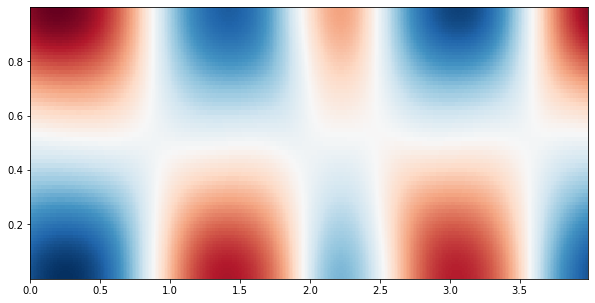

In [3]:
u = solver.state['u']
fig, axis = plt.subplots(figsize=(10,5))
p = axis.pcolormesh(xm, ym, u['g'].T, cmap='RdBu_r');

## Exercise

Plot the other flow quantities in a similar way.

1. Which other field quantities are there that can be plotted?
2. Plot all these other quantities and finally try to understand what they tell you about the flow.
3. Advanced: Try combining u and w to plot the direction of the flow as a map. How could one do that?

## Some Nusselt stuff below here

Below I show some flux and Nusselt computations from first principles (i.e. the fields themselves). It shows what the fields look like, the flux distribution and how to manually average over x and how that affects Nu calculations.

For simplicity I have chosen the fields at the end of this particular calculation (viscous time was around 0.4). Obviously other times can be chosen and in principle also temporal averaging is possible, although that needs inputs from fields at different times.

This will likely not solve your porblems but I think it more clearly shows what the issues are and perhaps Matt can use it to describe some issues and how to solve them by referring to someof the plots.

In [5]:
solver.sim_time

0.4000120221640634

In [6]:
def getfield(solver,name):
    field = solver.state[name]
    return field['g'].T

In [7]:
# here we get the 2D fields

Tf = getfield(solver,'T')
uf = getfield(solver,'u')
wf = getfield(solver,'w')
Tzf = getfield(solver,'Tz')

<IPython.core.display.Javascript object>


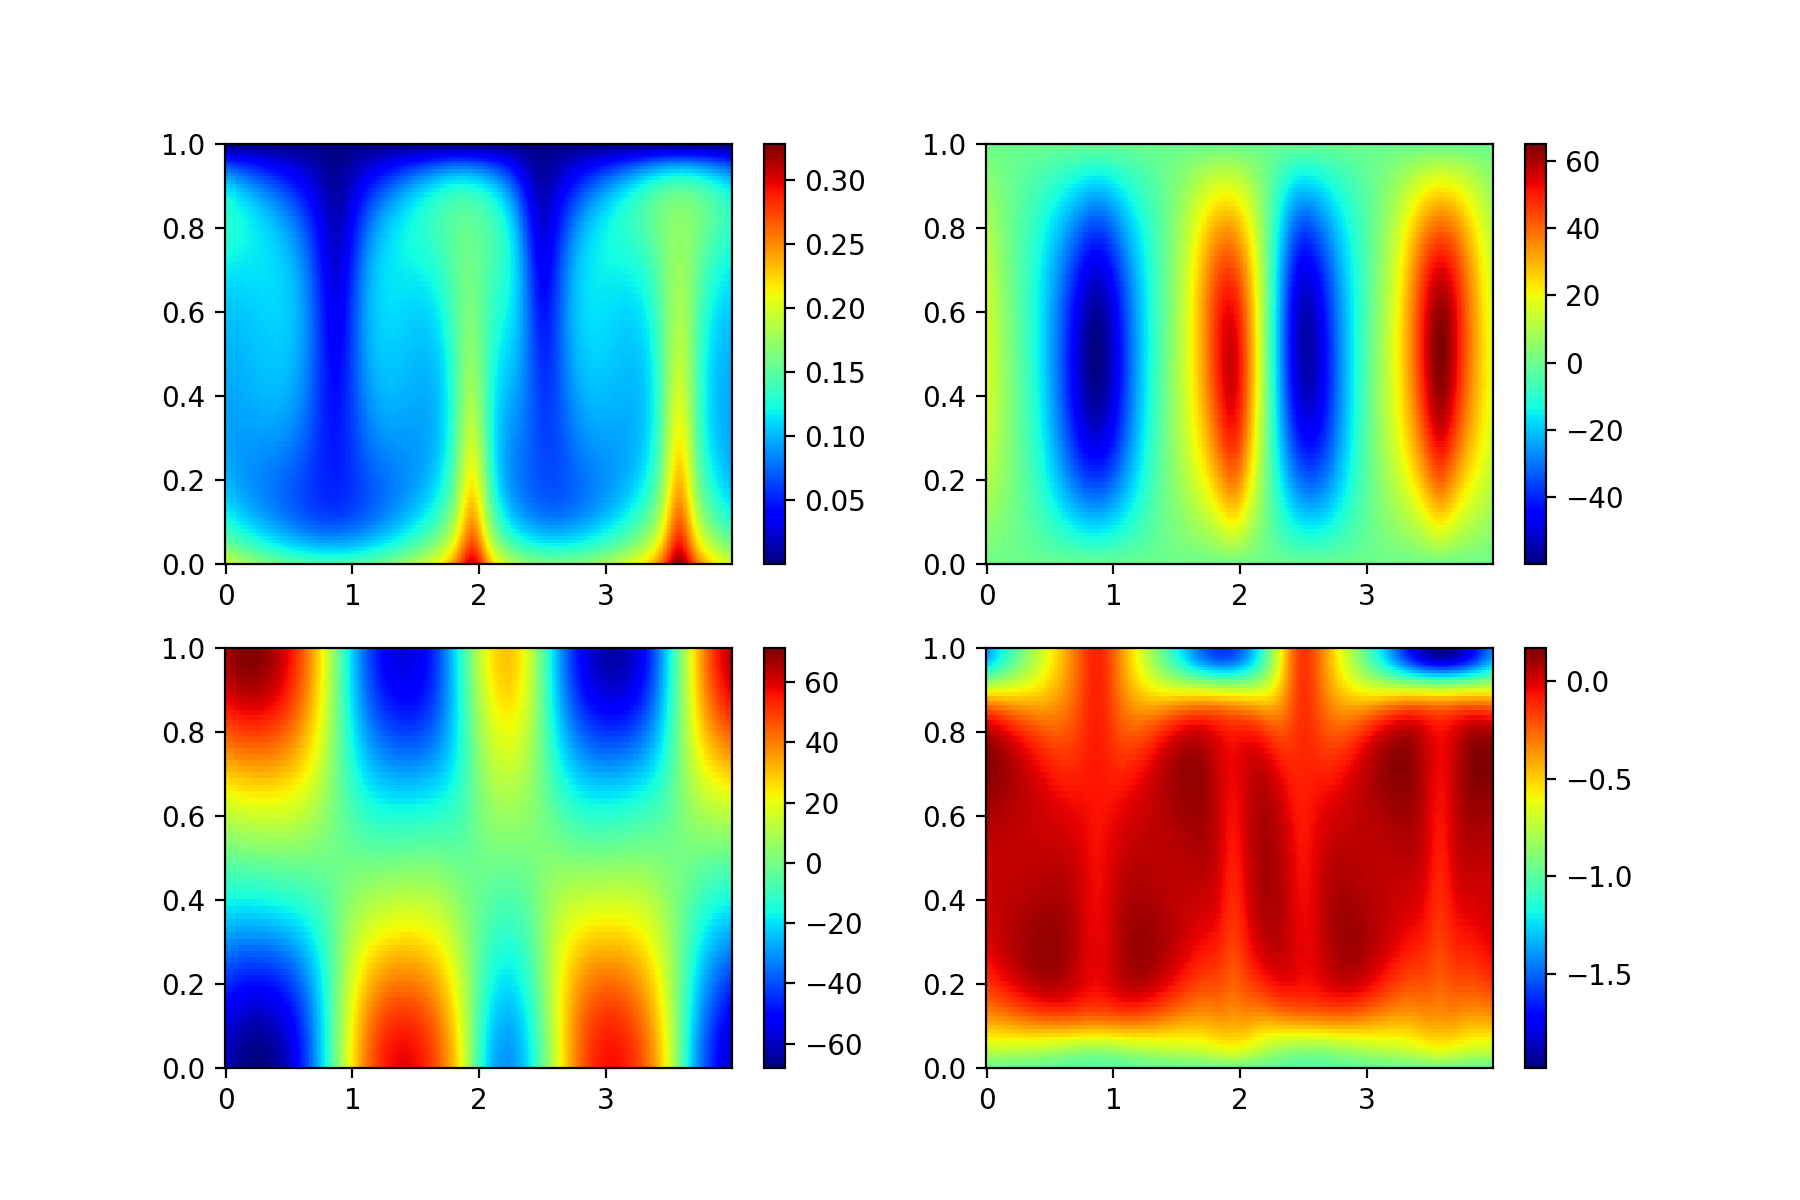

In [19]:
# that is what the fields look like

fig, axs = plt.subplots(2, 2, figsize=(9, 6))
im1 = axs[0, 0].pcolormesh(xm, ym, Tf, cmap='jet',shading='auto')
fig.colorbar(im1, ax=axs[0, 0])

im2 = axs[1, 0].pcolormesh(xm, ym, uf, cmap='jet',shading='auto')
fig.colorbar(im2, ax=axs[1, 0])

im3 = axs[0, 1].pcolormesh(xm, ym, wf, cmap='jet',shading='auto')
fig.colorbar(im3, ax=axs[0, 1])

im4 = axs[1, 1].pcolormesh(xm, ym, Tzf, cmap='jet',shading='auto')
fig.colorbar(im4, ax=axs[1, 1])

In [18]:
# this one is working out the pointwise fluxes

fconv = Tf*wf*Prandtl
fcond = -Tzf
Nuf = (fconv + fcond)/fcond

<IPython.core.display.Javascript object>


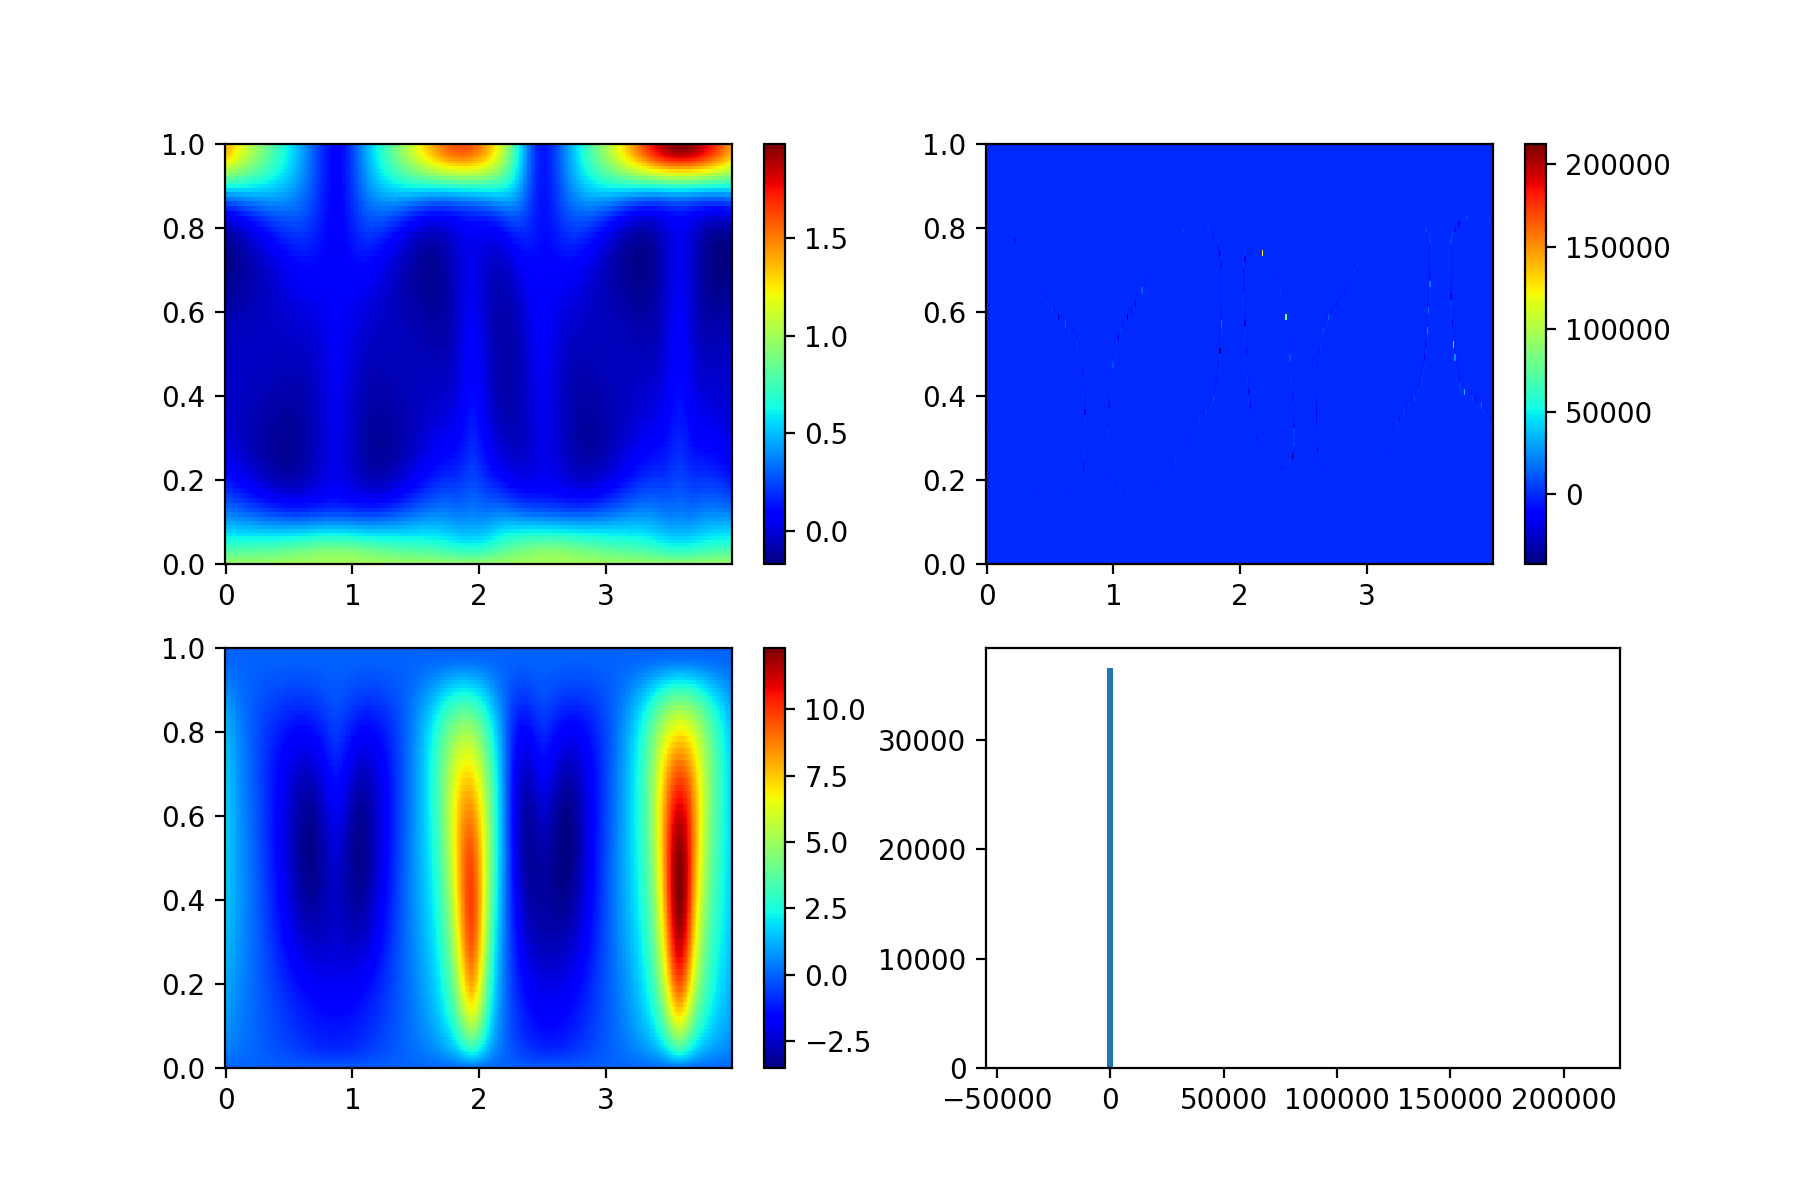

In [20]:
# that is what the flux fields look like

fig, axs = plt.subplots(2, 2, figsize=(9, 6))
im1 = axs[0, 0].pcolormesh(xm, ym, fcond, cmap='jet',shading='auto')
fig.colorbar(im1, ax=axs[0, 0])

im2 = axs[1, 0].pcolormesh(xm, ym, fconv, cmap='jet',shading='auto')
fig.colorbar(im2, ax=axs[1, 0])

# note the Nusselt field has very large local numbers where fcond is close to zero (no surprise)

im3 = axs[0, 1].pcolormesh(xm, ym, Nuf, cmap='jet',shading='auto')
fig.colorbar(im3, ax=axs[0, 1])

im4 = axs[1, 1].hist(Nuf.flatten(),bins=100)


<IPython.core.display.Javascript object>


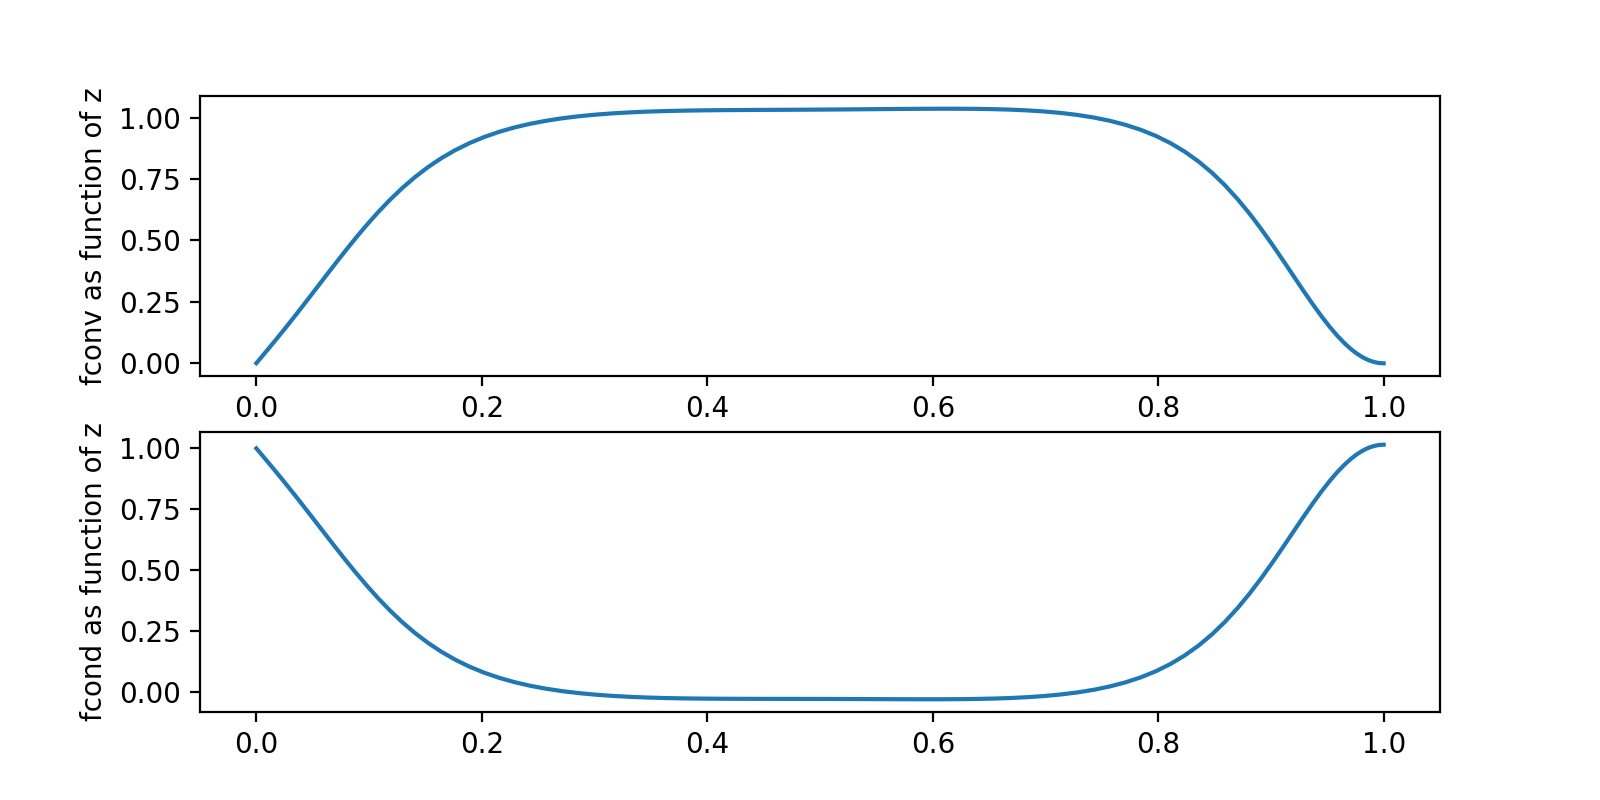

Text(0, 0.5, 'fcond as function of z')

In [39]:
# now we average a little along the horizontal axis
# this gives us the fluxes a function of z (I put the z-coordinate on the x-axis of the plots)

fconv_z = fconv.mean(axis = 1)
fcond_z = fcond.mean(axis = 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 4))
im1 = axs[0].plot(y.squeeze(),fconv_z)
axs[0].set_ylabel('fconv as function of z')
im2 = axs[1].plot(y.squeeze(), fcond_z)
axs[1].set_ylabel('fcond as function of z')

<IPython.core.display.Javascript object>


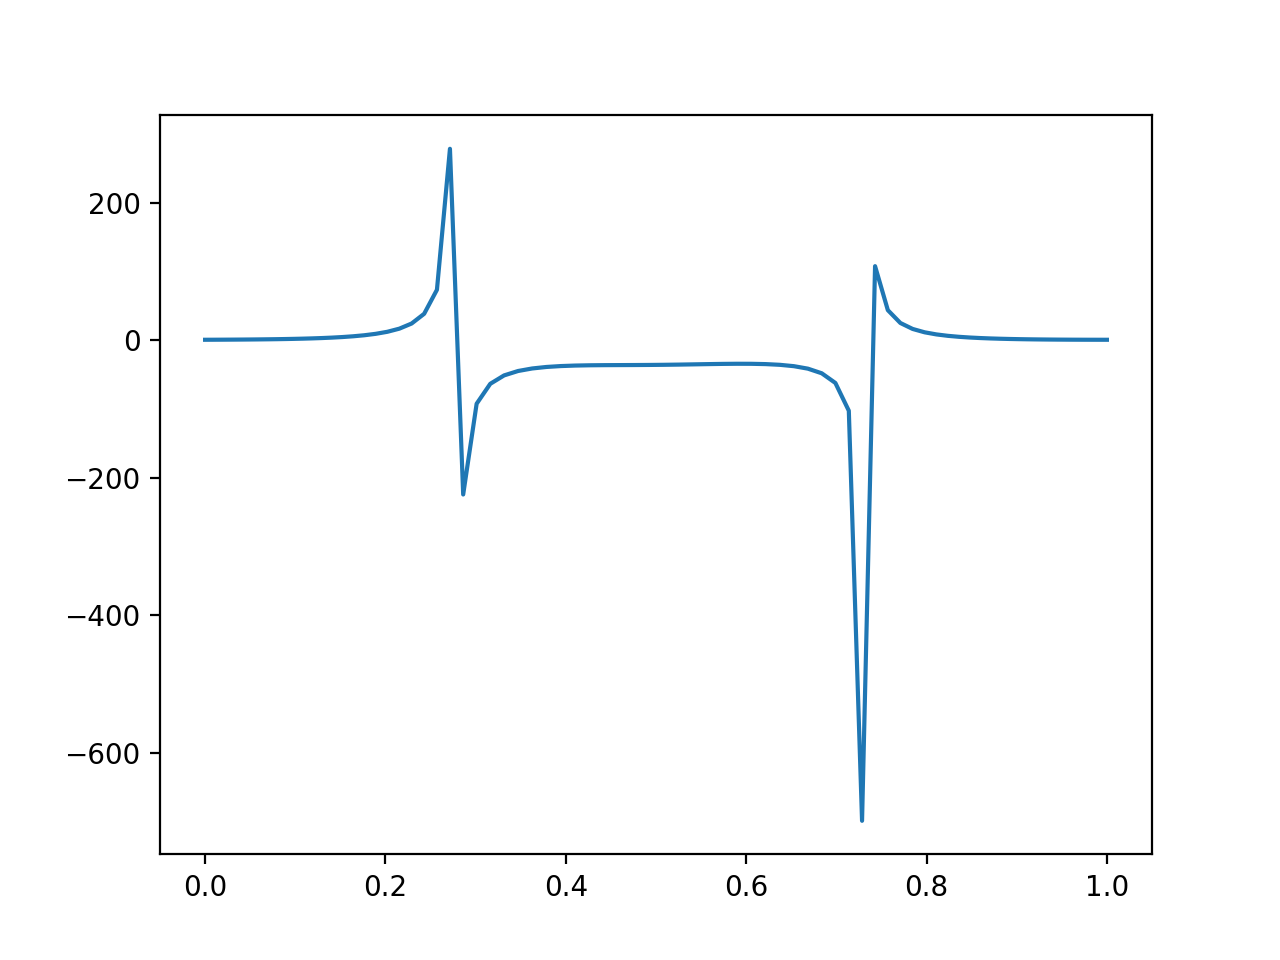

In [41]:
# now we can get an average Nusselt number as function of z
# it still has big spikes in areas where fconv is small

Nu_z = (fconv_z + fcond_z)/fcond_z

plt.figure()
plt.plot(y.squeeze(), Nu_z)